In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [162]:
ssr_raw_df = pd.read_csv("data/SSR_Apr2019_TrainTestData.csv", 
                     dtype={"USP_REV" : str, "TESTERSUBTYPE" : str })

In [193]:
# X is the first 50 columns. MSYE and MSYE_RULE are Y. Going to try 
# regression with the variable data first. 
# Drop all columns that have NaN in them - should figure out why and be sure it is fixed going forward. 
# Though actually, the GUIDs should only be for combining data from tables, not learning about it. Same with dates. 
# Until I figure out how to look at serial data for trends

# Make any adjustments to the raw SSR data pulled
ssr_df = ssr_raw_df.loc[(ssr_raw_df["LOTSCREENTYPE"] == "FIRST_PASS")].copy()
ssr_df.drop(["SEG_GUID", "PGM_GUID"], axis=1, inplace=True)
ssr_df.drop(["SETUP_START_DATE", "SETUP_END_DATE"], axis=1, inplace=True)
ssr_df.drop(["TTAPAG", "TESTERCONFIG", "PKG", "LBID"], axis=1, inplace=True)


In [194]:
# Check for any remaining Nan value in the data
ssr_df.isnull().values.ravel().sum()

0

In [195]:
len(ssr_df)

25085

In [196]:

X = ssr_df.iloc[:, 0:len(ssr_df.columns)-2]
y = ssr_df["MSYE"].values.reshape(-1, 1)

print(len(X), len(y))

25085 25085


In [197]:
# Now need to one hot encode all the stuff in X that is categorical. 
X = pd.get_dummies(X)
X.head()

,SETUP_TIME,CYCLES,TESTED_UNITS,RESCREEN_RULE,MSE_RULE,SPC_RULE,INDEX_RULE,MCBJ_RULE,SETUPTIME_RULE,MSE_UNIT,...,TESTERHEAD_vl77_1,TESTERHEAD_vl82_1,TESTERHEAD_vl88_1,TESTERHEAD_vl91_1,TESTERHEAD_vl93_1,TESTERHEAD_vl95_1,TESTERHEAD_vl98_1,TESTERHEAD_vl99_1,TESTERHEAD_vl9_1,LOTSCREENTYPE_FIRST_PASS
0,10.7,423,1888,1,1,1,1,1,1,1.000,...,0,0,0,0,0,0,0,0,0,1
1,6.7,362,1647,1,1,1,1,1,1,0.997,...,0,0,0,0,0,0,0,0,0,1
3,9.6,15,180,1,1,1,1,1,1,0.982,...,0,0,0,0,0,0,0,0,0,1
4,13.4,22,267,1,1,1,1,1,1,0.987,...,0,0,0,0,0,0,0,0,0,1
5,4.6,961,1159,1,1,1,1,1,1,1.000,...,0,0,0,0,0,0,0,0,0,1


In [198]:
# Be sure we understand the shape of the data for learning
print("Shape", X.shape)

Shape (25085, 4855)


In [199]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

print(len(X_train), len(y_train), len(X_test), len(y_test))

18813 18813 6272 6272


In [200]:
print(len(X_train), X_train.shape, y_train.shape)

18813 (18813, 4855) (18813, 1)


In [201]:
# Scale the data. This may not be necessary for linear regressions, but will be if I go to some other scheme
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [202]:
# Tranform all of the da
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [203]:
print(len(X_train_scaled), len(y_train_scaled), len(X_test_scaled), len(y_test_scaled))

18813 18813 6272 6272


In [204]:
stats.describe(y_train)

DescribeResult(nobs=18813, minmax=(array([0.057]), array([1.])), mean=array([0.95310121]), variance=array([0.00668282]), skewness=array([-3.92287119]), kurtosis=array([21.47052904]))

In [205]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=9)

# Fitting our model with all of our features in X
model.fit(X_train, y_train)

score = model.score(X_train, y_train)
print(f"R2 Score: {score}")

R2 Score: 0.5617203373151567


In [206]:
score = model.score(X_test, y_test)
print(f"R2 Score: {score}")

R2 Score: 0.46625101061045016


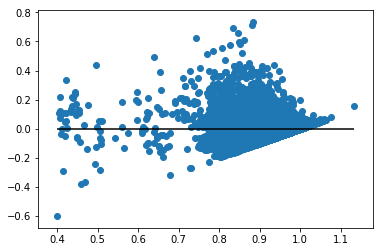

In [207]:
predictions = model.predict(X_train)
plt.scatter(predictions, predictions - y_train)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

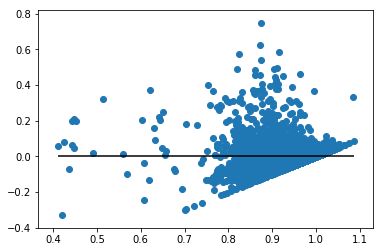

In [208]:
predictions = model.predict(X_test)
plt.scatter(predictions, predictions - y_test)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [66]:
test_df = X_test.copy()
test_df["MSYE"] = y_test
test_df["Predictions"] = predictions

In [67]:
test_df.to_csv("data/product_test_data.csv")

In [68]:
coefficients = pd.DataFrame({"Feature":X.columns,"Coefficients":np.transpose(model.coef_[0])})
coefficients

,Coefficients,Feature
0,-4.414183e-06,SETUP_TIME
1,-7.952746e-06,CYCLES
2,3.402100e-06,TESTED_UNITS
3,4.314340e-02,RESCREEN_RULE
4,-2.472786e-02,MSE_RULE
5,1.796645e-02,SPC_RULE
6,-2.242510e-03,INDEX_RULE
7,4.026895e-03,MCBJ_RULE
8,2.238784e-03,SETUPTIME_RULE
9,-4.814146e-02,MSE_UNIT


In [69]:
coefficients.to_csv("data/product_test_coefficients.csv")

C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.304802975751901e-17 / 1.1102230246251565e-16
  RuntimeWarning)


LogReg Count accuracy at alpha=0.0001: 0.45954740906378094
LogReg Count accuracy at alpha=0.001: 0.45958958748861833
LogReg Count accuracy at alpha=0.01: 0.46000653634616673
LogReg Count accuracy at alpha=0.1: 0.4637591245468927
LogReg Count accuracy at alpha=0.2: 0.4672403015737925
LogReg Count accuracy at alpha=0.3: 0.470194126034312
LogReg Count accuracy at alpha=0.4: 0.47274561848981067
LogReg Count accuracy at alpha=0.5: 0.47497853834247034
LogReg Count accuracy at alpha=0.6: 0.4769528519778967
LogReg Count accuracy at alpha=0.7: 0.4787133887649509
LogReg Count accuracy at alpha=0.8: 0.48029468355138555
LogReg Count accuracy at alpha=0.9: 0.4817239364769749
LogReg Count accuracy at alpha=1: 0.4830229428240698
LogReg Count accuracy at alpha=5: 0.5008957854642493
LogReg Count accuracy at alpha=6: 0.5021884409684418
LogReg Count accuracy at alpha=7: 0.5030801113804986
LogReg Count accuracy at alpha=8: 0.5036838181346343
LogReg Count accuracy at alpha=9: 0.5040719452198023
LogReg Coun

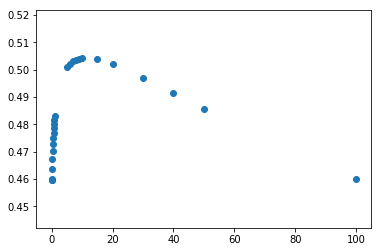

In [70]:
alpha_vals = [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1,5,6,7,8,9,10,15,20,30,40,50,100]
scores = []
for i in alpha_vals:
    model = Ridge(alpha=i)
    # Fitting our model with all of our features in X
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    scores.append(accuracy)
    print(f"LogReg Count accuracy at alpha={i}: {accuracy}")
    
plt.scatter(alpha_vals, scores)

LogReg Count accuracy at alpha=1: 0.5025166314579192
LogReg Count accuracy at alpha=2: 0.5036413033742247
LogReg Count accuracy at alpha=3: 0.5042289558442284


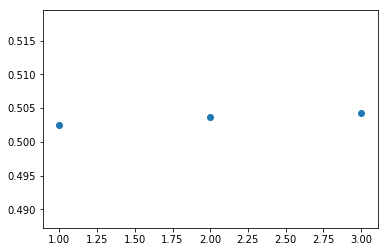

In [154]:
from sklearn.linear_model import BayesianRidge
alpha_vals = [1,2,3]
scores = []
for i in alpha_vals:
    model = BayesianRidge(alpha_1=i, alpha_2=i)
    # Fitting our model with all of our features in X
    model.fit(X_train, np.concatenate(y_train, axis=0))
    accuracy = model.score(X_test, np.concatenate(y_test, axis=0))
    scores.append(accuracy)
    print(f"LogReg Count accuracy at alpha={i}: {accuracy}")

plt.scatter(alpha_vals, scores)

In [134]:
model.coef_

array([-4.39607200e-06, -7.94530864e-06,  3.40999976e-06, ...,
        1.17629001e-03, -2.22659183e-02,  0.00000000e+00])

In [135]:
coefficients = pd.DataFrame({"Feature":X.columns,"Coefficients":np.transpose(model.coef_)})
coefficients

,Coefficients,Feature
0,-4.396072e-06,SETUP_TIME
1,-7.945309e-06,CYCLES
2,3.410000e-06,TESTED_UNITS
3,4.326100e-02,RESCREEN_RULE
4,-2.456712e-02,MSE_RULE
5,1.797629e-02,SPC_RULE
6,-2.195067e-03,INDEX_RULE
7,3.997698e-03,MCBJ_RULE
8,2.287855e-03,SETUPTIME_RULE
9,-4.690710e-02,MSE_UNIT


In [136]:
coefficients.to_csv("data/product_test_coefficients_Bayesian.csv")

In [137]:
predictions = model.predict(X_test)
test_df = X_test.copy()
test_df["MSYE"] = y_test
test_df["Predictions"] = predictions

In [138]:
test_df.to_csv("data/product_test_data_Bayesian.csv")

In [146]:
from sklearn.decomposition import PCA
p1_pca = PCA(n_components=2).fit(X_train)
p1_cum_var = 0
print ("Explained Variance:")
for i in range(50):
    p1_cum_var += p1_pca.explained_variance_ratio_[i]
    print ("Component",i,":",p1_pca.explained_variance_ratio_[i],"---", "Cumulative:", p1_cum_var)

Explained Variance:
Component 0 : 0.5894608340177069 --- Cumulative: 0.5894608340177069
Component 1 : 0.3715636577504962 --- Cumulative: 0.9610244917682031


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
p1_pca = PCA(n_components=126).fit(X_train)


Text(0.5,1,'2-Component PCA')

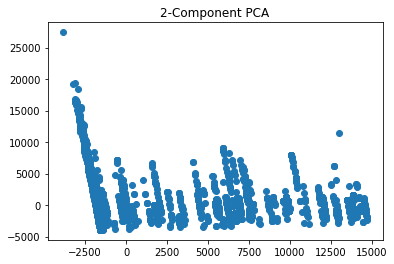

In [151]:
p2_pca=PCA(n_components=44)
p2_2dim_pca = p2_pca.fit_transform(X_train)

# Split 2d PCA data into poisonous and not-poisonous sets
# pca_pos_train = p2_2dim_pca[np.where(train_labels==1)]
# pca_neg_train = p2_2dim_pca[np.where(train_labels==0)]

# Plot the data
# plt.scatter(pca_neg_train[:,0],pca_neg_train[:,1],c='r',label="Not Poisonous")
plt.scatter(p2_2dim_pca[:,0],p2_2dim_pca[:,1])
# plt.scatter(p2_2dim_pca)
plt.title("2-Component PCA")

In [152]:
p2_2dim_pca_test = p2_pca.transform(X_test)


In [160]:
from sklearn.linear_model import Lasso
alpha_vals = [0.00001, 0.00005, 0.0001, 0.0002]
for i in alpha_vals:
    l_model=Lasso(alpha=i, tol = 0.1, max_iter=2000)

# Fitting our model with all of our features in X
    l_model.fit(X_train, np.concatenate(y_train, axis=0))
    accuracy = l_model.score(X_test, np.concatenate(y_test, axis=0))
    scores.append(accuracy)
    print(f"LogReg Count accuracy at alpha={i}: {accuracy}")

LogReg Count accuracy at alpha=1e-05: 0.4721482913970115
LogReg Count accuracy at alpha=5e-05: 0.48536205790014403
LogReg Count accuracy at alpha=0.0001: 0.4677353803608769
LogReg Count accuracy at alpha=0.0002: 0.4380527102292017
